Loading 10 trajectories for CHARMM36m_TIP3P...
 Loaded trajectory 1
 Loaded trajectory 2
 Loaded trajectory 3
 Loaded trajectory 4
 Loaded trajectory 5
 Loaded trajectory 6
 Loaded trajectory 7
 Loaded trajectory 8
 Loaded trajectory 9
 Loaded trajectory 10
Successfully loaded 10 trajectories
Combined shape: (10, 50000, 21)
Fitting IVAC model...
IVAC fit complete. Found 22 timescales
Extracted tICs [1, 2]
Setting up featurizer with structure: ../data/ivac/trajs/VPG_solv_ions.gro
Added 21 distance features
Found target feature: DIST: GLY 1 C 7 - VAL 4 C 46 at index 1
Found target feature: DIST: VAL 4 C 46 - VAL 7 C 83 at index 16


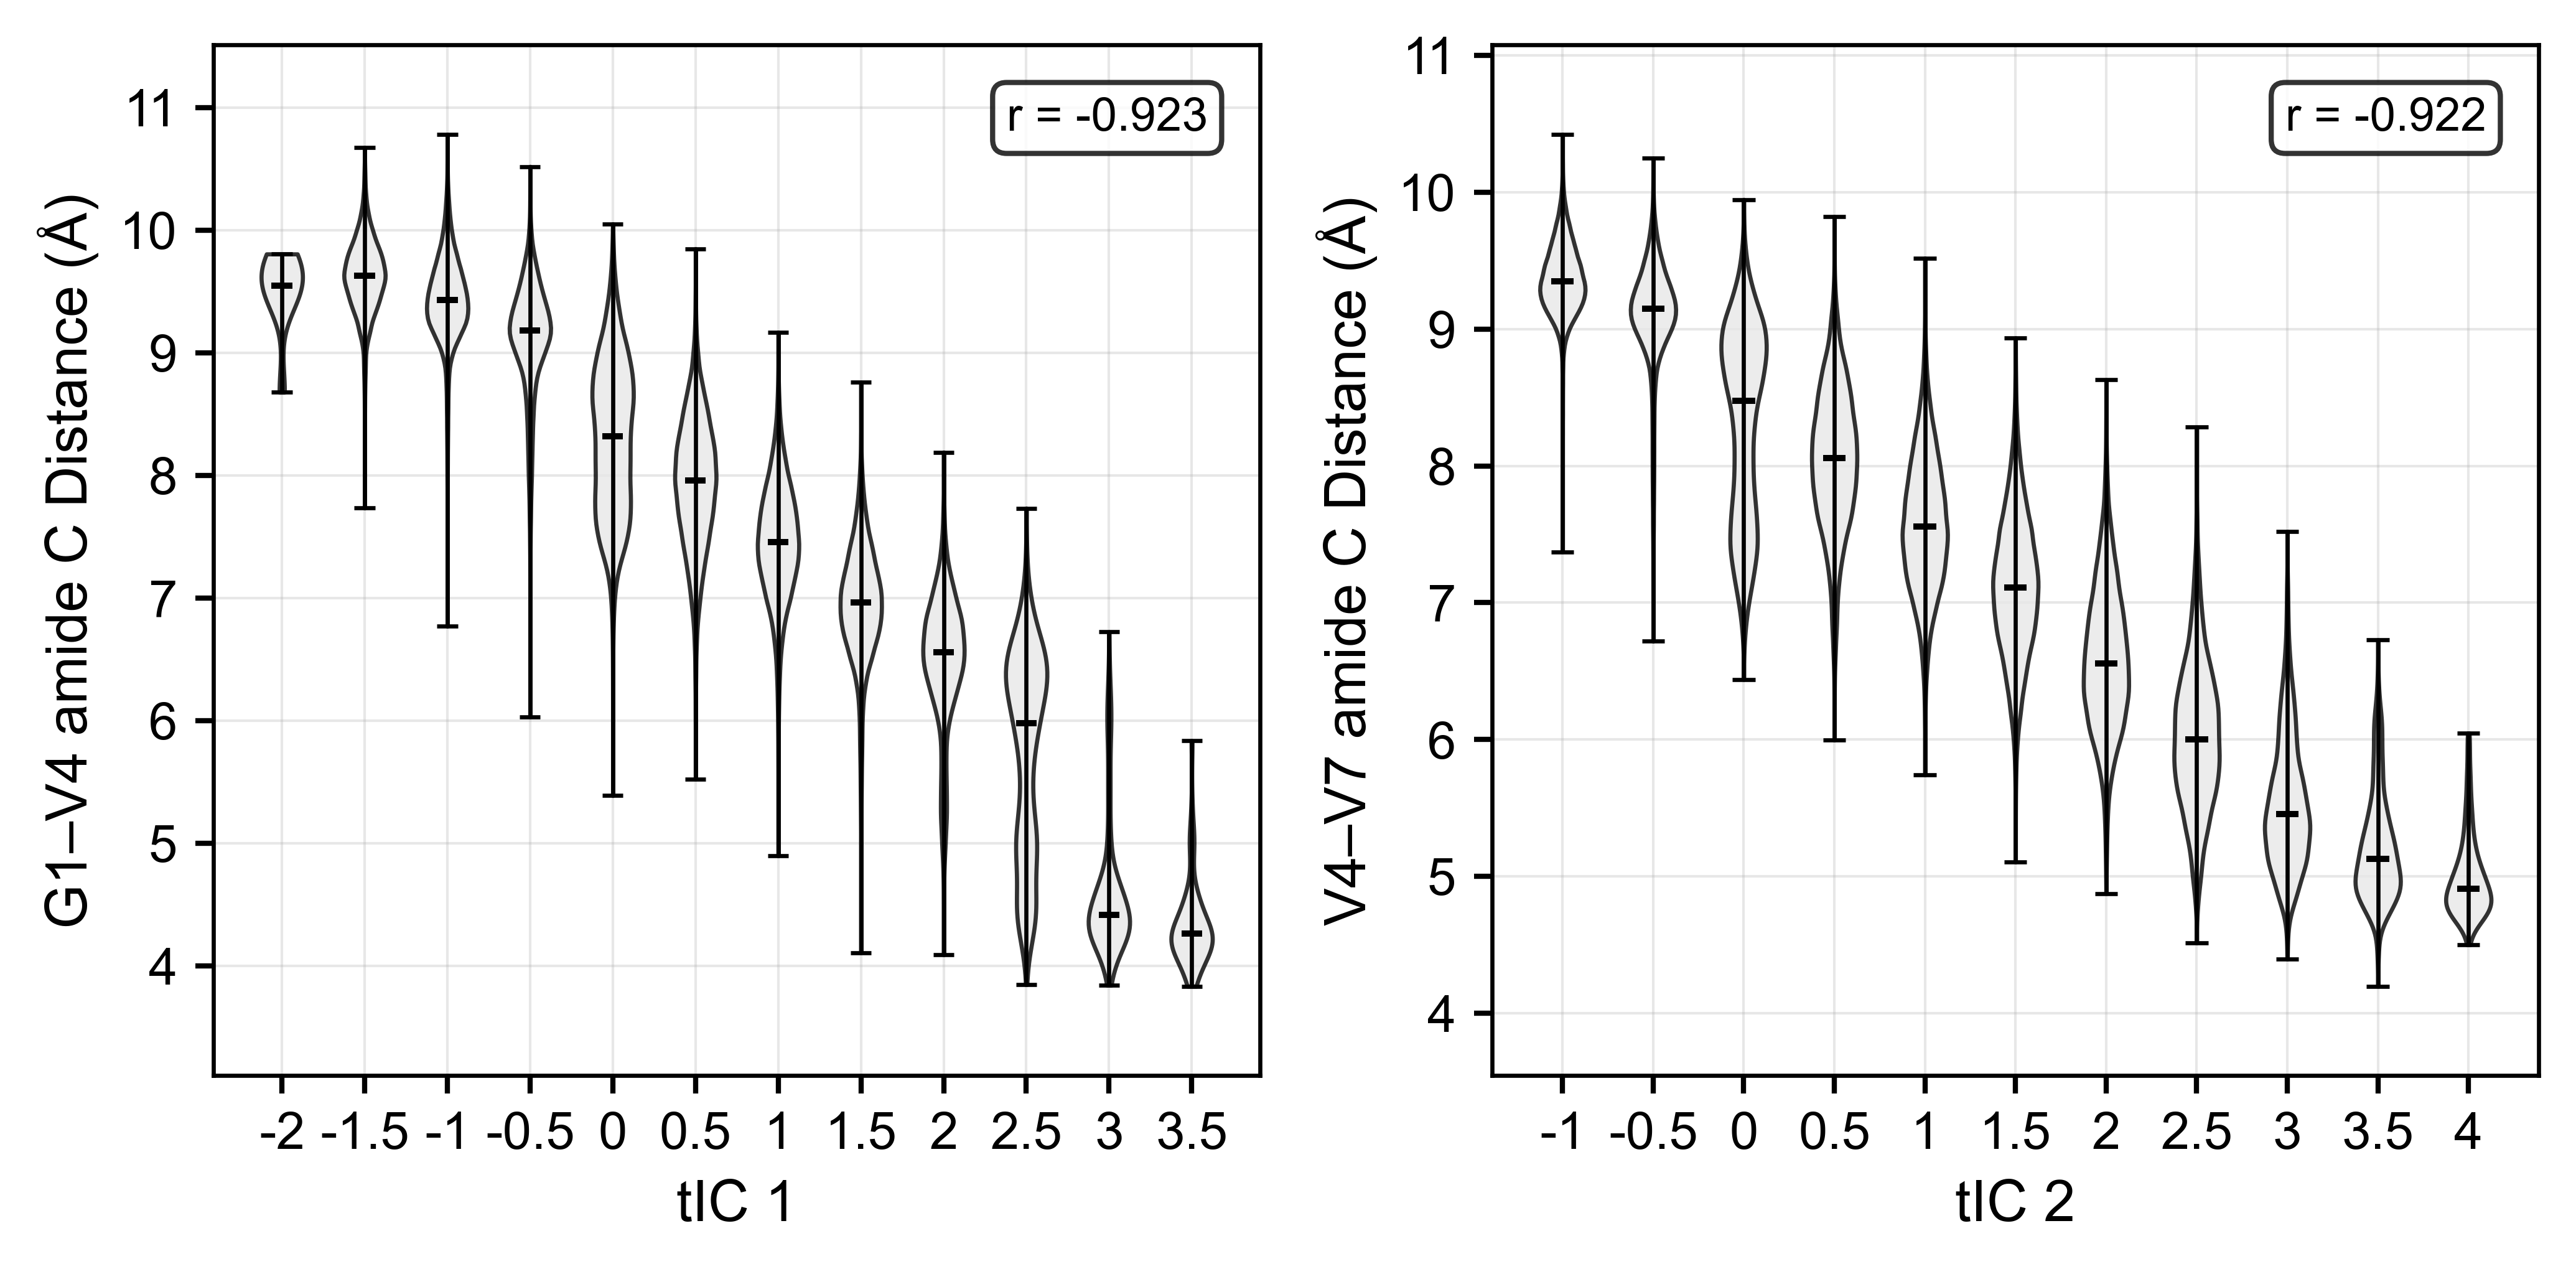


IVAC violin plot analysis completed successfully!


In [1]:
### PLOTS IVAC CALIBRATION CURVES FOR FIRST 2 EVECS (FIG S04) ###
### 2 Aug 2025 ###

import numpy as np
import matplotlib.pyplot as plt
import pyemma
from pathlib import Path
from scipy.stats import pearsonr
from ivac import LinearIVAC

# -----------------------------------------------------------------------------
# CONFIGURATION
# -----------------------------------------------------------------------------

# Paths
BASE_DIR = Path('../data')
FEAT_DIR = BASE_DIR / 'ivac' / 'feat'
TRAJ_DIR = BASE_DIR / 'ivac' / 'trajs'

# Data Specifications
FORCE_FIELD = 'CHARMM36m_TIP3P'
NUM_TRAJECTORIES = 10
STRUCTURE_FILE = 'VPG_solv_ions.gro'

# Analysis Parameters
CONV = 100
MIN_LAG = 0.1
MAX_LAG = 1
N_EIGENVECTORS = 20
IVAC_SETTINGS = {
    'reweight': True,
    'addones': True,
    'method': 'fft',
    'adjust': True
}

# Feature Specifications
NM_TO_ANGSTROM = 10.0
TARGET_FEATURES = [      # these features which were determined to have high correlation with the tICs
    'DIST: GLY 1 C 7 - VAL 4 C 46',
    'DIST: VAL 4 C 46 - VAL 7 C 83'
]
FEATURE_LABELS = {
    'y_labels': [r'G1–V4 amide C Distance (Å)', r'V4–V7 amide C Distance (Å)']
}

# Binning Parameters
BIN_WIDTH = 0.5  # 0.5 to get centers at 0, 0.5, 1, 1.5, 2, 2.5, etc.
MIN_SAMPLES_PER_BIN = 10

# Plotting Specifications
FIGURE_SIZE = (7, 3.5)
DPI = 300

# -----------------------------------------------------------------------------
# DATA LOADING
# -----------------------------------------------------------------------------

def load_all_trajectories(): # identical to fig S03
    """Load and combine all trajectory feature files."""
    trajectories = []
    print(f"Loading {NUM_TRAJECTORIES} trajectories for {FORCE_FIELD}...")
    
    for i in range(1, NUM_TRAJECTORIES + 1):
        filename = f'C_feat_{FORCE_FIELD}_{i}.npy'
        filepath = FEAT_DIR / filename
        
        if filepath.exists():
            trajectory = np.load(filepath)
            trajectories.append(trajectory)
            print(f" Loaded trajectory {i}")
        else:
            print(f" Warning: Trajectory file not found: {filepath}")
    
    if not trajectories:
        raise RuntimeError("No trajectory files were successfully loaded")
    
    combined_trajectories = np.stack(trajectories, axis=0)
    print(f"Successfully loaded {len(trajectories)} trajectories")
    print(f"Combined shape: {combined_trajectories.shape}")
    
    return combined_trajectories

def setup_featurizer():
    """Initialize PyEMMA featurizer with structure file."""
    structure_path = TRAJ_DIR / STRUCTURE_FILE
    
    if not structure_path.exists():
        raise FileNotFoundError(f"Missing structure file: {structure_path}")
    
    print(f"Setting up featurizer with structure: {structure_path}")
    return pyemma.coordinates.featurizer(str(structure_path))

def add_distance_features(featurizer):
    """This is the same featurization used for the trajectories,
    so that we can match them exactly.
    """
    atoms = featurizer.topology.atoms
    
    # Find amide C atoms
    atom_indices = []
    residue_indices = []
    
    for i, atom in enumerate(atoms):
        if atom.name == 'C':  
            atom_indices.append(i)
            residue_indices.append(atom.residue.index)
    
    # Create distance pairs (residues at least 2 apart)
    distance_pairs = []
    for i in range(len(atom_indices)):
        for j in range(i + 1, len(atom_indices)):
            if abs(residue_indices[i] - residue_indices[j]) >= 2:
                distance_pairs.append((atom_indices[i], atom_indices[j]))
    
    featurizer.add_distances(distance_pairs, periodic=True)
    print(f"Added {len(distance_pairs)} distance features")
    return featurizer.describe()

def get_feature_indices(feature_descriptions):
    """Get indices of target features from full feature list."""
    feature_indices = []
    
    for target_feature in TARGET_FEATURES:
        try:
            index = feature_descriptions.index(target_feature)
            feature_indices.append(index)
            print(f"Found target feature: {target_feature} at index {index}")
        except ValueError:
            raise ValueError(f"Target feature not found: {target_feature}")
    
    return feature_indices

# -----------------------------------------------------------------------------
# ANALYSIS
# -----------------------------------------------------------------------------

def fit_ivac_model(trajectories):
    """Fit IVAC model and return transformed eigenvectors and concatenated features."""
    print("Fitting IVAC model...")
    
    # Convert lag times to steps
    min_lag_steps = int(CONV * MIN_LAG)
    max_lag_steps = int(CONV * MAX_LAG)
    
    # Initialize and fit IVAC
    ivac = LinearIVAC(
        min_lag_steps, 
        max_lag_steps,
        nevecs=N_EIGENVECTORS, 
        **IVAC_SETTINGS
    )
    
    ivac.fit(trajectories)
    
    # Transform to eigenvector space and concatenate and transpose
    eigenvectors_transformed = ivac.transform(trajectories)
    eigenvectors_concatenated = np.concatenate(eigenvectors_transformed, axis=0).T
    
    # Concatenate and transpose original trajectories
    trajectories_concatenated = np.concatenate(trajectories, axis=0).T
    
    print(f"IVAC fit complete. Found {len(ivac.its)} timescales")
    
    return ivac, eigenvectors_concatenated, trajectories_concatenated

def get_tics(eigenvectors_concatenated, indices=[1, 2]): # first 2, figure S03 shows timescale separation after 2nd evec
    """Extract specified eigenvectors (tICs)."""
    tics = [eigenvectors_concatenated[i] for i in indices]
    print(f"Extracted tICs {indices}")
    return tics

def convert_distances_to_angstrom(trajectories_concatenated):
    """Convert distance units from nm to Angstroms."""
    return trajectories_concatenated * NM_TO_ANGSTROM

# -----------------------------------------------------------------------------
# PLOTTING
# -----------------------------------------------------------------------------

def set_plot_style():
    """Set consistent plot style for ACS publication figures."""
    plt.rcParams.update({
        # Font settings - Arial (PC) or Helvetica (Mac) as per ACS
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],
        'font.size': 10,  # Will be readable at 5pt when reduced to column width
        
        # Line widths - minimum 1 pt as per ACS
        'lines.linewidth': 1.0,
        'axes.linewidth': 1.0,
        'xtick.major.width': 1.0,
        'ytick.major.width': 1.0,
        'xtick.minor.width': 1.0,
        'ytick.minor.width': 1.0,
        'patch.linewidth': 1.0,
        'grid.linewidth': 1.0,
        
        # Font sizes - accounting for reduction
        'axes.labelsize': 11,
        'axes.titlesize': 12,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # DPI settings
        'figure.dpi': 600
    })

def style_violin_plot(violin_parts):
    """Apply consistent styling to violin plot components."""
    for body in violin_parts['bodies']:
        body.set_facecolor('#E8E8E8')
        body.set_edgecolor('black')
        body.set_linewidth(0.8)
        body.set_alpha(0.8)
    
    # Style other violin components
    for component_name in ['cmedians', 'cmaxes', 'cmins', 'cbars']:
        if component_name in violin_parts:
            violin_parts[component_name].set_colors('black')
            linewidth = 1.2 if component_name == 'cmedians' else 0.8
            violin_parts[component_name].set_linewidth(linewidth)

def add_correlation_text(ax, x_data, y_data):
    """Calculate and add Pearson correlation (r) between tIC and input feature."""
    correlation, _ = pearsonr(x_data, y_data)
    ax.text(0.95, 0.95, f'r = {correlation:.3f}', 
            ha='right', va='top', transform=ax.transAxes, 
            fontsize=9, bbox=dict(boxstyle='round,pad=0.3', 
                                facecolor='white', alpha=0.8))

def style_axes(ax):
    """Apply consistent styling to axes."""
    ax.grid(True, alpha=0.3, linestyle='-', linewidth=0.5)
    ax.set_axisbelow(True)
    
    for spine in ax.spines.values():
        spine.set_linewidth(0.8)
        spine.set_color('black')
    
    # Add padding to y-limits
    y_min, y_max = ax.get_ylim()
    padding = 0.05 * (y_max - y_min)
    ax.set_ylim(y_min - padding, y_max + padding)

def create_violin_plot(ax, tic_data, distance_data, feature_index):
    """Create single violin plot panel with binning and styling."""
    # Find data range
    data_min = tic_data.min()
    data_max = tic_data.max()
    
    # Create bin edges aligned to ensure centers are at 0, 0.5, 1, 1.5, etc.
    # Start from -0.25 below the nearest 0.5 multiple
    bin_start = np.floor(data_min / BIN_WIDTH) * BIN_WIDTH - BIN_WIDTH/2
    bin_end = np.ceil(data_max / BIN_WIDTH) * BIN_WIDTH + BIN_WIDTH/2
    bins = np.arange(bin_start, bin_end + BIN_WIDTH/2, BIN_WIDTH)
    
    # Calculate bin centers (will be at 0, 0.5, 1, 1.5, 2, 2.5, etc.)
    bin_centers = bins[:-1] + BIN_WIDTH/2
    
    # Assign data points to bins
    bin_indices = np.clip(np.digitize(tic_data, bins) - 1, 0, len(bins) - 2)
    
    # Collect data for each bin with sufficient samples
    binned_data = []
    bin_labels = []
    bin_positions = []
    
    for j in range(len(bin_centers)):
        mask = bin_indices == j
        
        if np.sum(mask) > MIN_SAMPLES_PER_BIN:
            binned_data.append(distance_data[mask])
            
            # Create bin label using the center value
            center = bin_centers[j]
            # Format as integer if it's an integer, otherwise one decimal
            if abs(center - round(center)) < 1e-10:
                label = str(int(round(center)))
            else:
                label = f'{center:.1f}'
            
            bin_labels.append(label)
            bin_positions.append(len(bin_positions))
    
    # Create violin plot if we have data
    if binned_data:
        violin_parts = ax.violinplot(
            binned_data, 
            positions=bin_positions,
            showmeans=False,
            showmedians=True,
            showextrema=True
        )
        
        style_violin_plot(violin_parts)
        
        ax.set_xticks(bin_positions)
        ax.set_xticklabels(bin_labels)
    
    # Set labels and styling
    ax.set_xlabel(f'tIC {feature_index + 1}')
    ax.set_ylabel(FEATURE_LABELS['y_labels'][feature_index])
    
    add_correlation_text(ax, tic_data, distance_data)
    style_axes(ax)

# -----------------------------------------------------------------------------
# MAIN
# -----------------------------------------------------------------------------

def main():
    """Main function to run IVAC analysis and generate violin plots."""
    set_plot_style()
    
    try:
        # Load trajectory data
        trajectories = load_all_trajectories()
        
        # Fit IVAC model
        ivac_obj, eigenvectors_concat, trajectories_concat = fit_ivac_model(trajectories)
        
        # Extract tICs
        tics = get_tics(eigenvectors_concat)
        
        # Convert distances to Angstroms (since input features are in nm)
        distances_angstrom = convert_distances_to_angstrom(trajectories_concat)
        
        # Setup featurizer and get feature indices
        featurizer = setup_featurizer()
        feature_descriptions = add_distance_features(featurizer)
        target_indices = get_feature_indices(feature_descriptions)
        
        # Create violin plots
        fig, axes = plt.subplots(1, 2, figsize=FIGURE_SIZE)
        
        for i, (ax, tic, feature_idx) in enumerate(zip(axes, tics, target_indices)): # 2 of them
            create_violin_plot(ax, tic, distances_angstrom[feature_idx], i)
        
        plt.tight_layout()
        plt.show()
        
        print("\nIVAC violin plot analysis completed successfully!")
        
    except Exception as e:
        print(f"Error during analysis: {e}")
        raise

if __name__ == "__main__":
    main()